In [93]:
# Import libraries
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

In [2]:
# load data
dfy = pd.read_csv("labels_train.csv")
y = []
for val in range(dfy.shape[0]):
    y.append(dfy.iloc[val][0])
y = np.asarray(y)

dfx = pd.read_csv("msgs_vec_train.csv")
X = []
for row in range(dfx.shape[0]):
    vec = []
    for val in dfx.iloc[row]:
        vec.append(val)
    X.append(vec)
X = np.asarray(X)
print(y.shape,X.shape)

(21840,) (21840, 500)


In [3]:
# preprocess y data to categories
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
Y = one_hot_encode(y)
Y.shape
print(Y[5].dtype)
tf.__version__

float64


'2.2.0'

In [109]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='relu'))
# Add another:
model.add(layers.Dense(100, activation='relu'))
# model.add(layers.Dense(500, activation='relu')
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [110]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      f1_score
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.05),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=METRICS)
# model.summary();

# MeanSquaredError 
# CategoricalCrossentropy
# MeanAbsolutePercentageError 
# CategoricalHinge 

In [111]:
# train model
history = model.fit(X, Y, epochs=10, validation_split=0.3, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')])

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

478/478 [==============================] - 2s 4ms/step - loss: 0.2452 - accuracy: 0.1409 - precision: 0.1409 - recall: 0.1406 - auc: 0.4988 - f1_score: 0.1405 - val_loss: 0.2444 - val_accuracy: 0.1447 - val_precision: 0.1447 - val_recall: 0.1447 - val_auc: 0.5011 - val_f1_score: 0.1446
Epoch 2/10
478/478 [==============================] - 2s 4ms/step - loss: 0.2454 - accuracy: 0.1412 - precision: 0.1412 - recall: 0.1412 - auc: 0.4990 - f1_score: 0.1411 - val_loss: 0.2444 - val_accuracy: 0.144

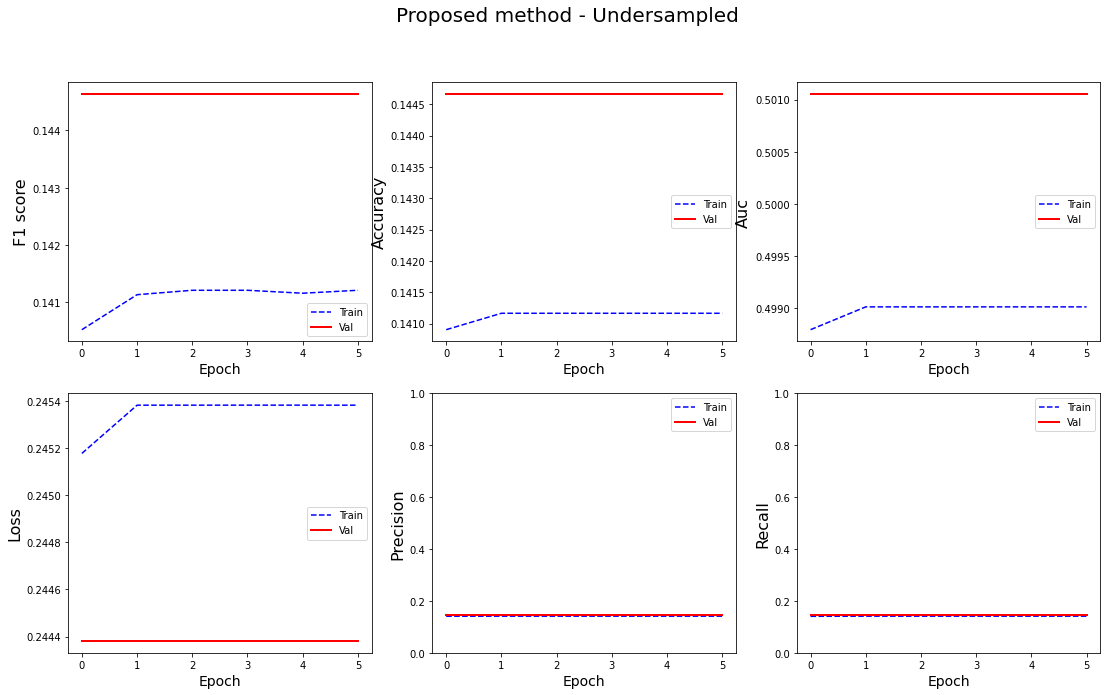

In [112]:
figName = "Proposed method - Undersampled"

metrics =  ['f1_score', 'accuracy','auc', 'loss', 'precision', 'recall']
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')